# Activity Classification - DNN2 Training

This notebook trains our second Deep Neural Network on the physical activity dataset.


## Load Data and Prepare Training Set

In [1]:
%reset -f

import importlib
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import activity_functions
importlib.reload(activity_functions)

from activity_functions import *

In [2]:
activtity = load_data()

Loaded from Kaggle: /home/thuy/.cache/kagglehub/datasets/diegosilvadefrana/fisical-activity-dataset/versions/4/dataset2.csv


In [3]:
df_train, df_test = create_train_test(activtity, test_ratio=0.2)

In [4]:
X_train, y_train, X_test, y_test = prepare_for_train(df_train, df_test)

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## Hyperband + Regularization

In [6]:
tuner = kt.Hyperband(
    build_model_cnn,
    objective="val_accuracy",
    max_epochs=50,
    factor=3,
    directory="dnn2",
    project_name="hyperband_tuning"
)

tuner.search(
    X_train,
    y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    verbose=1
)

Trial 90 Complete [01h 56m 04s]
val_accuracy: 0.3839288353919983

Best val_accuracy So Far: 0.991028904914856
Total elapsed time: 1d 22h 07m 15s


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"  {hp_name}: {best_hps.get(hp_name)}")


Best hyperparameters:
  learning_rate: 0.0007187981375915335
  optimizer: adam
  weight_decay: 0.0001
  dropout: 0.1
  n_conv_layers: 3
  n_dense_layers: 3
  filters_0: 32
  kernel_0: 2
  filters_1: 128
  kernel_1: 5
  filters_2: 64
  kernel_2: 5
  dense_units: 256
  filters_3: 128
  kernel_3: 3
  filters_4: 128
  kernel_4: 3
  tuner/epochs: 50
  tuner/initial_epoch: 17
  tuner/bracket: 3
  tuner/round: 3
  tuner/trial_id: 0046


## Fit Best Model

In [8]:
best_model = tuner.hypermodel.build(best_hps)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7,
    restore_best_weights=True
)

history = best_model.fit(
    X_train,
    y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.8725 - loss: 0.4463 - val_accuracy: 0.9167 - val_loss: 0.2886
Epoch 2/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 139s 78ms/step - accuracy: 0.9379 - loss: 0.2327 - val_accuracy: 0.9401 - val_loss: 0.2175
Epoch 3/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 139s 78ms/step - accuracy: 0.9543 - loss: 0.1829 - val_accuracy: 0.9630 - val_loss: 0.1569
Epoch 4/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 139s 78ms/step - accuracy: 0.9634 - loss: 0.1571 - val_accuracy: 0.9673 - val_loss: 0.1441
Epoch 5/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 139s 78ms/step - accuracy: 0.9691 - loss: 0.1409 - val_accuracy: 0.9494 - val_loss: 0.1992
Epoch 6/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 140s 78ms/step - accuracy: 0.9724 - loss: 0.1315 - val_accuracy: 0.9772 - val_loss: 0.1191
Epoch 7/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 140s 78ms/step - accuracy: 0.9751 - loss: 0.1234 - val_accuracy: 0.9752 - val_loss: 0.1211
Epoch 8/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 140s 78ms/step - accuracy: 

#### Accuracy Plot

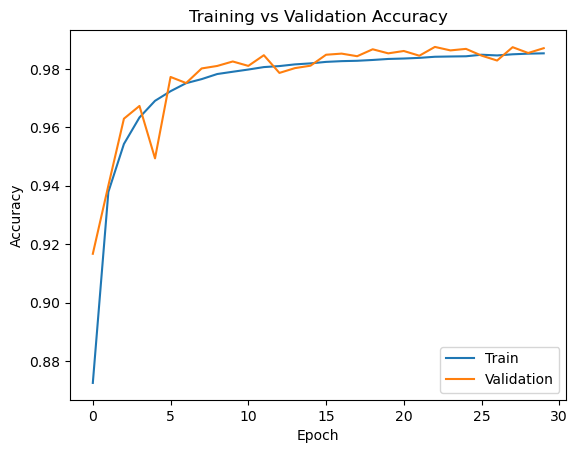

In [9]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

#### Loss Plot

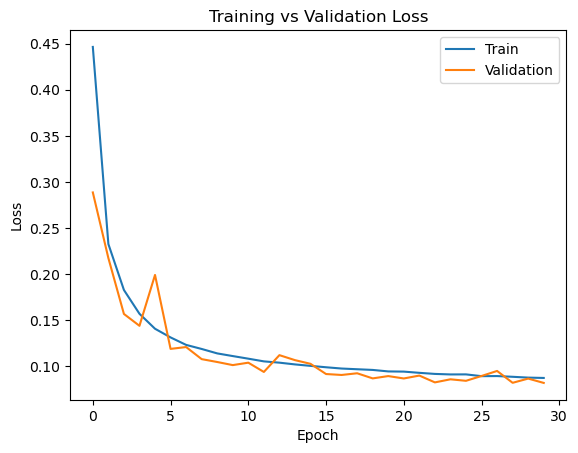

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Train", "Validation"])
plt.show()


## Model Evaluation

In [11]:
y_test_hat = best_model.predict(X_test)
y_test_pred = np.argmax(y_test_hat, axis=1)
compute_scores(y_test_encoded, y_test_pred, verbose=True)

17901/17901 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step
Accuracy:  0.9875
F1-Score:  0.9869
Recall:    0.9882
Precision: 0.9856


,Accuracy,F1_Score,Recall,Precision
0,0.987465,0.986896,0.988223,0.985637


## Summary
Our hyperband achieved a good result of over 98% accuracy. We will be using the best parameters for our final model. Here are the results of our hyperband:


`Best hyperparameters:
  learning_rate: 0.0007187981375915335
  optimizer: adam
  weight_decay: 0.0001
  dropout: 0.1
  n_conv_layers: 3
  n_dense_layers: 3
  filters_0: 32
  kernel_0: 2
  filters_1: 128
  kernel_1: 5
  filters_2: 64
  kernel_2: 5
  dense_units: 256
  filters_3: 128
  kernel_3: 3
  filters_4: 128
  kernel_4: 3
  tuner/epochs: 50
  tuner/initial_epoch: 17
  tuner/bracket: 3
  tuner/round: 3
  tuner/trial_id: 0046`